In [2]:
# IMPORTS
import sys
!{sys.executable} -m pip install mmh3
import mmh3
from bitarray import bitarray
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import numpy as np
import random

In [3]:
# VARIABLES and DATA STRUCTURES

documents = ["vocab.pubmed.txt","vocab.nytimes.txt","vocab.nps.txt","vocab.kos.txt","vocab.enron.txt"]

#sample 1/5 of the dataset to create tghe bloom filter
#use the remaining elements to test the false positive rate
sample_freq = 0.2

#test bloom filter sizes ranging from 1-20 bits per entry
max_bloom_size = 20

#test bloom filter using 1-8 hash functions
num_hash = 8

In [27]:
#READ IN DATA
datasets = []
for document in documents:
    file = open(document, encoding="utf8")
    file_content = file.read().split('\n')
    datasets.append(file_content)

In [4]:
# IMPLEMENTATION OF BLOOM FILTER METHODS
class BloomFilter():
    
    def __init__(self,size,num_hash):
        self.size = size
        self.num_hash = num_hash
        self.array = size*bitarray('0')
        self.seed = 0
        
    def add(self,element):
        for _ in range(self.num_hash):
                self.array[self._hash(element)]=1
                
    def __contains__(self,element):
        for _ in range(self.num_hash):
                if not (self.array[self._hash(element)]):
                    return False
        return True
    
    #In order to generate different hash functions- we can set the seed of MurmurHash (mmh3.hash)
    def _hash(self,element):
        #each time we create a new hash function- increment the seed
        self.seed= (self.seed+1)%self.num_hash
        return mmh3.hash(element,self.seed)%self.size

In [5]:
#Create a bloom filter from a dataset and test the false positive rate
def runtrial(i,sample_freq,alpha,num_hash):
    trial_set = datasets[i] 
    
    #randomly sample from the dataset
    sample = [x for x in trial_set if random.random()<sample_freq]
    dict = {x:1 for x in sample}           
      
    #alpha parameter determines the bits per element ratio of the bloom filter
    size= alpha*len(sample)
    
    #add the elements from the sample to the bloom filter
    bloom = BloomFilter(size,num_hash)
    for value in sample:
        bloom.add(value)
    
    #find the elements not in the sample
    negatives = [x for x in trial_set if x not in dict]
    
    #if an element is not in the sample, but querying the bloom filter with the element returns True, then record a false positive
    false_pos = [x for x in negatives if x in bloom]
    
    #return the false positive rate
    return len(false_pos)/len(negatives)

In [7]:
#Find the false positive rate for the datasets for each of the different bloom filter sizes
def testallbloomsizes(max_bloom_size,num_hash):
    fp_values=[]
    #test each of the datasets
    for dataset in range(len(datasets)):
        results = []
        #for each dataset find the false positive rate for each of the given bloom filter sizes
        for i in range(1,max_bloom_size+1):
            res = runtrial(dataset,sample_freq,i,num_hash)
            results.append(res)
        fp_values.append(results)
    return fp_values

In [29]:
#calculate the expected false positive rate, given the bloom filter size (in bits per entry)
def fp_map(x):
    return 2**(-x/1.44)

In [30]:
#display the graph of average false positive rate of the datasets
def displayplot_avg(fp_values,num_hash):
    plt.figure()
    size = len(fp_values[0])+1
    
    #compute the average false positive rate of the bloom filters constructed with different datasets
    avg = np.mean([x for x in fp_values],axis=0)
    plt.plot(list(range(1,size)),avg,label="Average Value")
    
    #find the expected false positive values for each of the different bloom filter sizes
    projected = [fp_map(i) for i in range(1,size)]
    plt.plot(list(range(1,size)),projected,'k',label='Theoretical Value')
    
    plt.xlabel("Size: Bits per Entry")
    plt.ylabel("False Positive Rate")
    plt.title("False Positive Rate vs Bloom Filter Size: " + "( " + str(num_hash) +" hash functions )")
    
    #compute the mean absolute error between the actual and expected values
    MAE = round(mean_absolute_error(avg,projected),3)
    plt.figtext(.7,.7,"MAE = " +str(MAE))
    
    plt.legend()

**Experiments performed on NYTimes Bag of Words Dataset:**<br />
Test the bloom filters using 1-8 different hash functions<br />
Find the average false positive rate for each different filter size
<br />Compute the mean absolute error between the expected and actual false postive values

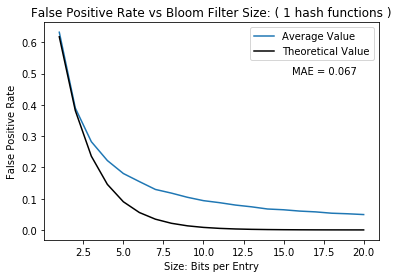

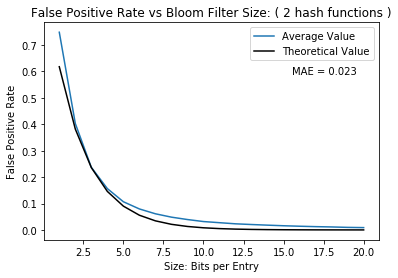

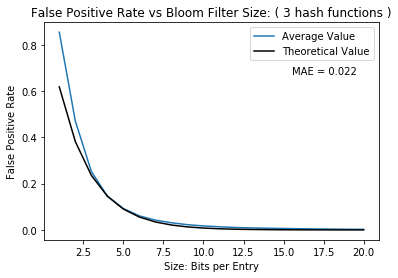

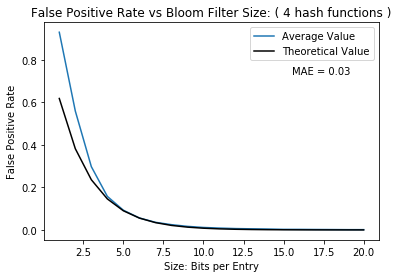

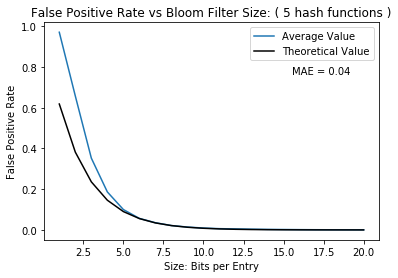

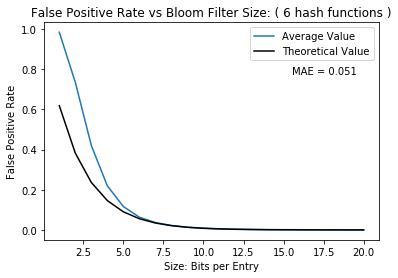

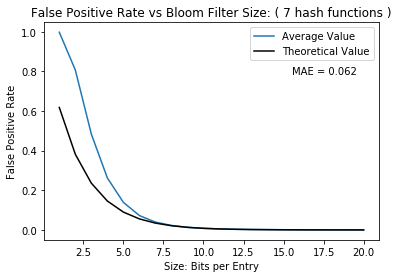

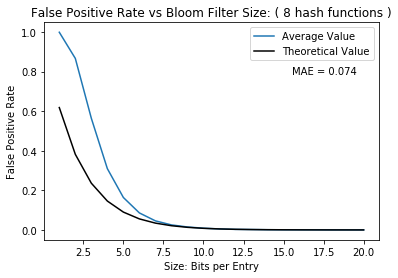

In [46]:
for i in range(1,num_hash+1):
    fp_values = testallbloomsizes(max_bloom_size,i)
    displayplot_avg(fp_values,i)